In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pprint import pprint

In [104]:
def l1_norm(d, s):
    return np.log(np.sum(np.abs(d)) / np.sum(np.abs(s)))


def dlnA(d, s):
    return 0.5 * np.log(np.sum(d ** 2) / np.sum(s ** 2))


def waveform_misfit(obs, syn):
    return np.linalg.norm(obs - syn)


def linear_factors(d, s):
    return np.sum(d * s) / np.sum(s * s)


def calculate_coef_metrics(obs, syn):
    scales = [1 + -0.20 + 0.01 * i for i in range(41)]
    #print("scales:", scales)
   
    dlnas = []
    wms = []
    l1s = []
    factors = []
    for s in scales:
        dlnas.append(dlnA(obs, s * syn))
        wms.append(waveform_misfit(obs, s * syn))
        l1s.append(l1_norm(obs, s * syn))
        factors.append(linear_factors(s * obs, syn))
    
    result = {
        "coef": scales,
        "l1_norm": np.array(l1s),
        "l2_norm": np.array(dlnas),
        "waveform_l2":np.array(wms),
        "linear_inv": np.array(factors)
    }
    #print(type(result))
    return result

In [105]:
def analyze_l1(results):
    scales = results["coef"]
    l1s = results["l1_norm"]
    
    plt.figure(figsize=(5, 4))
    plt.plot(scales, l1s**2, '.--', label='l1')
    ymin, ymax = plt.gca().get_ylim()
    plt.plot([1.0, 1.0], [ymin, ymax], '--')
    plt.plot([0.9, 1.1], [0, 0], '--')
    plt.legend()
    plt.xlabel("Amplitude Scaler")
    plt.ylabel("l1 norm")
    #plt.xticks(np.arange(0.9, 1.15, 0.05))
    plt.grid()
    plt.show()
    
    idx = np.argmin(l1s**2)
    print("estimated scales from l1: ", scales[idx])
    return scales[idx]
    
    
def analyze_l2(results):
    scales = results['coef']
    dlnas = results["l2_norm"]
    plt.figure(figsize=(5, 4))
    plt.plot(scales, dlnas ** 2, '.--', label='l2(dlnA)')
    ymin, ymax = plt.gca().get_ylim()
    plt.plot([1.0, 1.0], [ymin, ymax], '--')
    plt.plot([0.9, 1.1], [0, 0], '--')
    plt.xlabel("Amplitude Scaler")
    plt.ylabel("dlnA -- l2 norm")
    plt.legend()
    plt.grid()
    plt.show()
    
    idx = np.argmin(dlnas ** 2)
    print("estimated scales from l2: ", scales[idx])
    return scales[idx]


def analyze_waveform_misfit(results):
    scales = results["coef"]
    wms = results["waveform_l2"]
    
    plt.figure(figsize=(5, 4))
    plt.plot(scales, wms, '.--', label='waveform diff l2')
    plt.xlabel("Amplitude Scaler")
    plt.ylabel("Wavefrom Misfit")
    #plt.plot([0.9, 1.1], [0, 0], '--')
    ymin, ymax = plt.gca().get_ylim()
    plt.plot([1.0, 1.0], [ymin, ymax], '--')
    plt.legend()
    plt.grid()
    plt.show()
    
    idx = np.argmin(wms ** 2)
    print("estimated scales from waveform diff l2: ", scales[idx])
    return scales[idx]
    
    
def analyze_linear_inv(results):
    coef = results["coef"]
    
    plt.figure(figsize=(4, 4))
    plt.plot(results["coef"], results["linear_inv"], 'ko', label="predict")
    plt.gca().set_aspect('equal', adjustable='box')
    
    coefs = results["coef"]
    plt.plot(coefs, coefs, 'r--', label='true')
    #plt.plot([0.8, 1.2], [0, 0], '--')
    #plt.plot([1.0, 1.0], [-0.05, 0], '--')
    plt.xlabel("Amplitude Scaler")
    plt.ylabel("Linear Inverse Coef")
    plt.grid()
    plt.legend()
    plt.show()
    
    
def plot_obs_syn(obs, syn):
    plt.figure(figsize=(10, 4))
    plt.plot(obs, 'k', label='obs')
    plt.plot(syn, 'r', label='syn')
    plt.legend()
    plt.grid()
    plt.show()
    
    return obs, syn

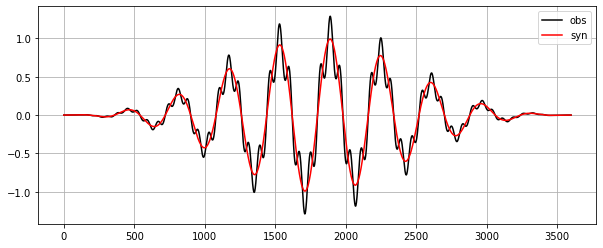

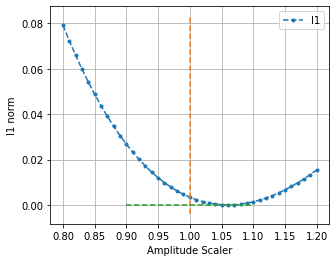

estimated scales from l1:  1.06


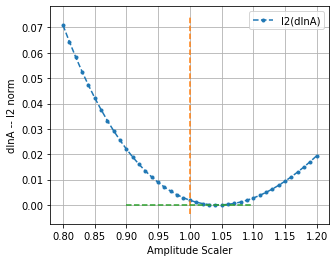

estimated scales from l2:  1.04


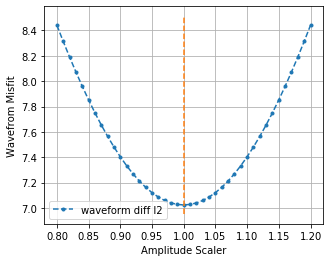

estimated scales from waveform diff l2:  1.0


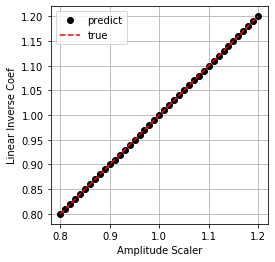

In [106]:
def generate_sine_noise():
    degs = np.arange(0, 360 * 10) / 180 * np.pi
    syn = np.sin(degs)
    tmp = np.arange(len(syn)) / 180 * np.pi
    noise = 0.3 * np.sin(tmp * 5)
    obs = syn + noise

    window = np.blackman(len(syn))
    syn *= window
    obs *= window
    
    plot_obs_syn(obs, syn)
    
    return obs, syn

obs, syn = generate_sine_noise()
results = calculate_coef_metrics(obs, syn)
analyze_l1(results)
analyze_l2(results)
analyze_waveform_misfit(results)
analyze_linear_inv(results)

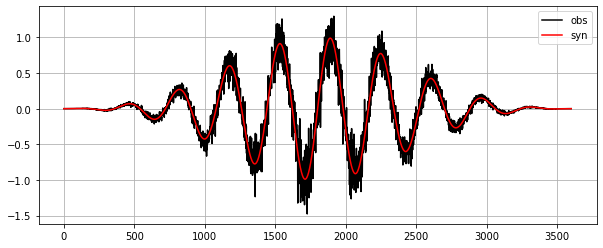

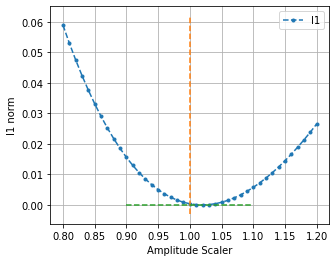

estimated scales from l1:  1.02


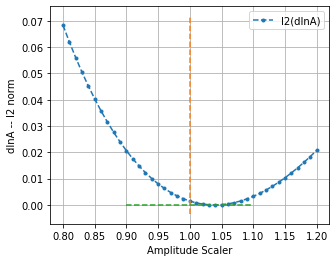

estimated scales from l2:  1.04


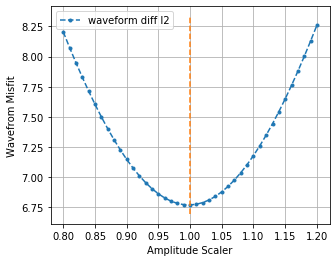

estimated scales from waveform diff l2:  1.0


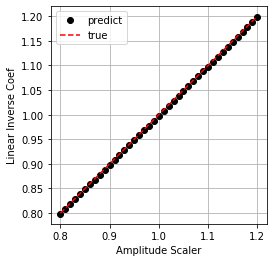

In [108]:
def generate_gauss_noise():
    degs = np.arange(0, 360 * 10) / 180 * np.pi
    syn = np.sin(degs)
    
    noise = 0.2 * np.random.randn(len(syn))
    
    obs = syn + noise
    window = np.blackman(len(syn))
    syn *= window
    obs *= window
    plot_obs_syn(obs, syn)
    
    return obs, syn

obs, syn = generate_gauss_noise()
results = calculate_coef_metrics(obs, syn)
analyze_l1(results)
analyze_l2(results)
analyze_waveform_misfit(results)
analyze_linear_inv(results)

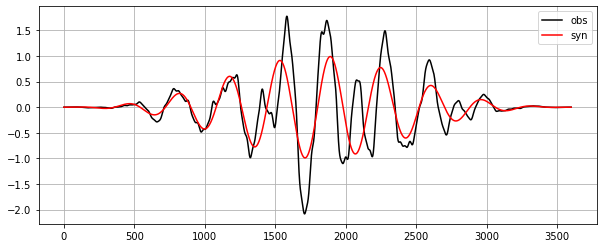

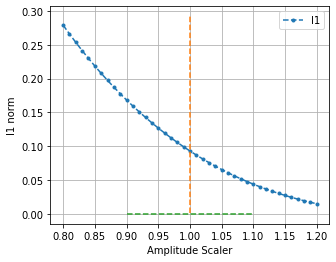

estimated scales from l1:  1.2000000000000002


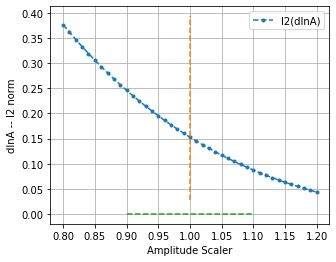

estimated scales from l2:  1.2000000000000002


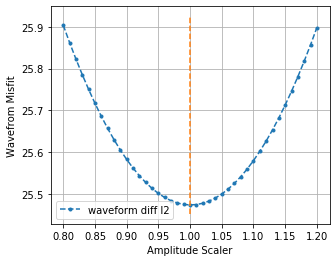

estimated scales from waveform diff l2:  1.0


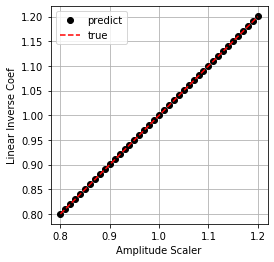

In [109]:
def generate_multiple_sine_noise():
    degs = np.arange(0, 360 * 10) / 180 * np.pi
    syn = np.sin(degs)
    obs = syn.copy()
    freq_coef = [1.43, 1.6, 1.83, 1.95, 2.1, 4.2, 6.2, 10.3]
    noise_level = [0.6, 0.6, 0.3, 0.2, 0.4, 0.1, 0.1, 0.05]
    for i in range(len(freq_coef)):
        tmp = np.arange(len(syn)) / 180 * np.pi
        noise = noise_level[i] * np.sin(tmp * freq_coef[i])
        obs += noise
    #obs += 0.2 * np.random.randn(len(syn))
    
    window = np.blackman(len(syn))
    syn *= window
    obs *= window
    plot_obs_syn(obs, syn)
    
    return obs, syn
    

obs, syn = generate_multiple_sine_noise()
results = calculate_coef_metrics(obs, syn)
analyze_l1(results)
analyze_l2(results)
analyze_waveform_misfit(results)
analyze_linear_inv(results)